# *Pytorch модель тест на полных данных

> *Экспресс-тест

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
import scipy.stats as stats
import seaborn as sns
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Подгрузка данных

In [11]:
df = pd.read_csv('data/rosstat_data_big.csv')
df= df.set_index('region')
df.shape

(83, 1108)

> В данных 83 строки и 1108 колонн (севатополь и крым исключены, т.к. высокий процент пропусков)

## Экспресс. Нормализация, Симметиря

In [12]:
def asym_test(df):
    col_names = list(df.columns)

    # списки для признаков
    sym = []       # симметричные
    asym = []      # с асимметрией

    alpha = 0.05

    for col in col_names:
        x = df[col]
        if len(x) < 8:  # тесты требуют минимум наблюдений
            continue

        # тест Д’Агостино–Пирсона (учитывает и асимметрию, и эксцесс)
        k2, p = stats.normaltest(x)

        if p <= alpha:
            asym.append(col)   # есть асимметрия/ненормальность
        else:
            sym.append(col)    # симметричное/нормальное распределение
            
    return sym, asym

sym, asym = asym_test(df)
print(f'Распределение симментрично: {len(sym)} признаков\nРаспределение ассимметрично: {len(asym)} признаков')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1687: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis, _no_deco=True)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1792: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False, _no_deco=True)


Распределение симментрично: 201 признаков
Распределение ассимметрично: 907 признаков


In [13]:
df_scal = df.copy()

In [14]:
pt = PowerTransformer(method="yeo-johnson", standardize=True)  # Yeo–Johnson
df_scal[list(asym)] = pt.fit_transform(df[list(asym)])

In [15]:
scaler = StandardScaler()
df_scal[list(sym)] = scaler.fit_transform(df[list(sym)])

In [26]:
# Функция оценки качества

def cluster_quality(X, labels):
    if len(set(labels)) < 2:
        return {"Silhouette": None, "CH": None, "DB": None}
    return {
        "Silhouette": silhouette_score(X, labels),
        "CH": calinski_harabasz_score(X, labels),
        "DB": davies_bouldin_score(X, labels)
    }

### Реализация DEC с нормализацией латента, k-means инициализацией центров и двумя регуляризациями

In [19]:
# превращаем масштабированный датафрейм в тензор
X = torch.tensor(df_scal.values, dtype=torch.float32)

# Количетсво кластеров
k = 4

# Количетсво компонент
d_lat = 16

# автоэнкодер сжимает из d_in в d_lat (24 компонент)
class AE(nn.Module):
    def __init__(self, d_in, d_lat):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(d_in, 64), nn.ReLU(), nn.Linear(64, d_lat))
        self.dec = nn.Sequential(nn.Linear(d_lat, 64), nn.ReLU(), nn.Linear(64, d_in))
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z), z

# присвоения q
class Clustering(nn.Module):
    def __init__(self, k, d_lat, alpha=1.0):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(k, d_lat))
        self.alpha = alpha
    def forward(self, z):
        # [n, k] квадр. расстояния
        dist = torch.cdist(z, self.centers)**2
        # q — это ненормированная вероятность принадлежности точки i к кластеру j
        q = (1.0 + dist/self.alpha) ** (-(self.alpha+1)/2)
        return q / q.sum(1, keepdim=True)

In [20]:
# целевая дистрибуция DEC

# Подсвечивает (усиливает) уверенные присвоения (q^2) и одновременно компенсирует слишком крупные кластеры (деление на f)

def target_distribution(q):
    f = q.sum(0, keepdim=True) + 1e-10          # частоты кластеров
    w = (q**2) / f
    return w / (w.sum(1, keepdim=True) + 1e-10)

# претрейн AE
ae = AE(X.shape[1], d_lat)

# учим AE восстанавливать вход (250 эпох на всем датасете без батчей)
opt = optim.Adam(ae.parameters(), lr=1e-3)
mse = nn.MSELoss()
for _ in range(250):
    opt.zero_grad()
    xrec, _ = ae(X)
    mse(xrec, X).backward(); opt.step()


In [21]:

# инициализация центров k-means в латенте
@torch.no_grad()
def torch_kmeans_init(Z, k, iters=50):
    n = Z.size(0)
    C = Z[torch.randperm(n)[:k]].clone()
    for _ in range(iters):
        lbl = torch.cdist(Z, C).argmin(1)
        C_new = torch.stack([Z[lbl==j].mean(0) if (lbl==j).any() else C[j] for j in range(k)])
        if torch.allclose(C, C_new, atol=1e-5): break
        C = C_new
    return C
with torch.no_grad():
    _, z0 = ae(X)
    z0 = F.normalize(z0, dim=1)           # L2-нормализация латента
clust = Clustering(k, d_lat)
clust.centers.data = torch.tensor(torch_kmeans_init(z0, k))

C:\Users\User\AppData\Local\Temp\ipykernel_25536\2120763209.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clust.centers.data = torch.tensor(torch_kmeans_init(z0, k))


In [22]:
# совместное обучение (DEC + слабая реконструкция + баланс кластеров)

params = list(ae.enc.parameters()) + list(clust.parameters())
opt = optim.Adam(params, lr=1e-3)
kl = nn.KLDivLoss(reduction="batchmean")
lambda_rec, beta_bal = 0.05, 0.005  # веса регуляризаций

for t in range(300):
    xrec, z = ae(X)
    z = F.normalize(z, dim=1)
    q = clust(z)
    p = target_distribution(q).detach()
    
    # основной DEC: KL(q || p)
    loss = kl((q+1e-10).log(), p)
    # «IDEС-подобная» стабилизация
    loss = loss + lambda_rec * mse(xrec, X)
    # средние веса кластеров
    pi = q.mean(0) + 1e-10
    loss = loss + beta_bal * (pi * pi.log()).sum()
    opt.zero_grad(); loss.backward(); opt.step()

cluster_dec
3    23
2    22
1    19
0    19
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_25536\3364495521.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_scal["cluster_dec"] = labels


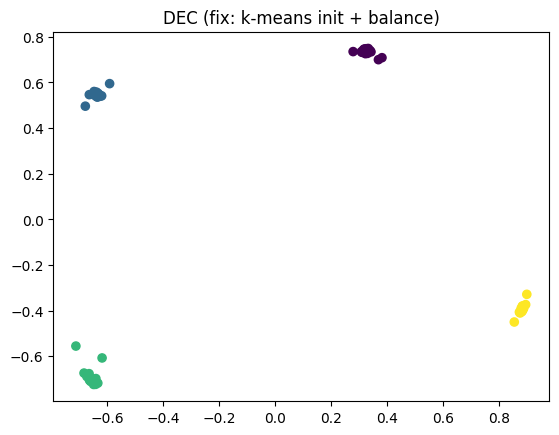

In [23]:
# Визуализация
with torch.no_grad():
    _, z = ae(X); z = F.normalize(z, dim=1)
    q = clust(z); labels = q.argmax(1).cpu().numpy()
df_scal["cluster_dec"] = labels
print(df_scal["cluster_dec"].value_counts())

xy = PCA(2).fit_transform(z.cpu().numpy())
plt.scatter(xy[:,0], xy[:,1], c=labels, s=35)
plt.title("DEC (fix: k-means init + balance)"); plt.show()


In [27]:
cluster_quality(X, labels)

{'Silhouette': np.float32(0.03442739),
 'CH': np.float32(7.586109),
 'DB': np.float64(2.9349783803660525)}

> Метрики слабые. Данные плохо обработаны. Много шума

### Проверка статистик

In [28]:
df= pd.read_csv('data/rosstat_data_scal.csv')
df = df[~df.index.isin(["севастополь", "республика_крым"])]
df = df.set_index('region')

In [29]:
df = pd.concat([df, df_scal['cluster_dec']], axis=1)

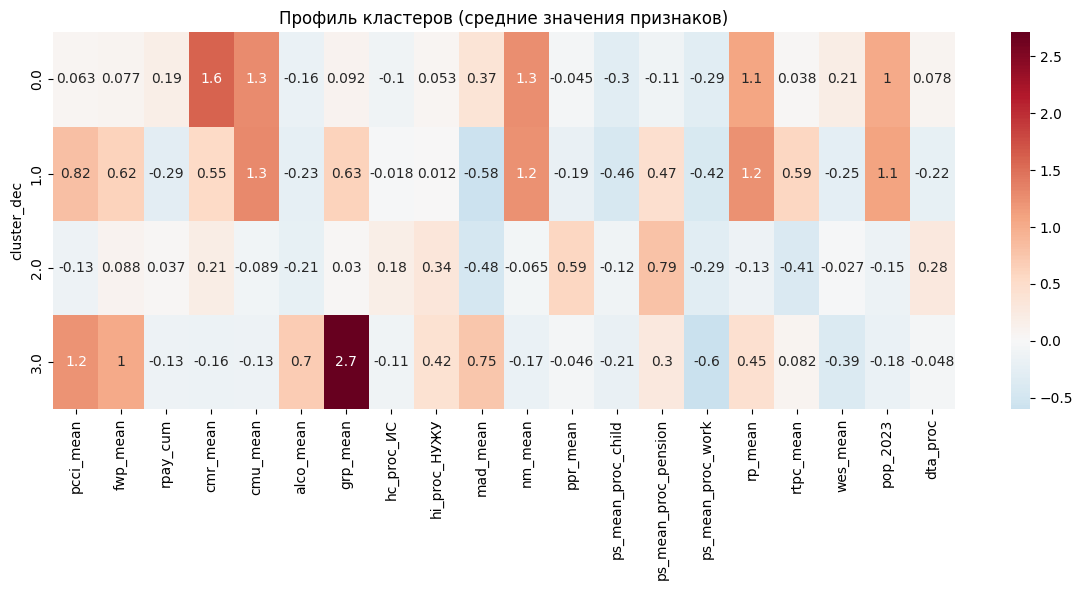

In [32]:
df = df.groupby("cluster_dec").mean()

# Тепловая карта распределения
plt.figure(figsize=(12,6))
sns.heatmap(df, cmap="RdBu_r", annot = True, center=0)
plt.title("Профиль кластеров (средние значения признаков)")
plt.tight_layout()
plt.show()

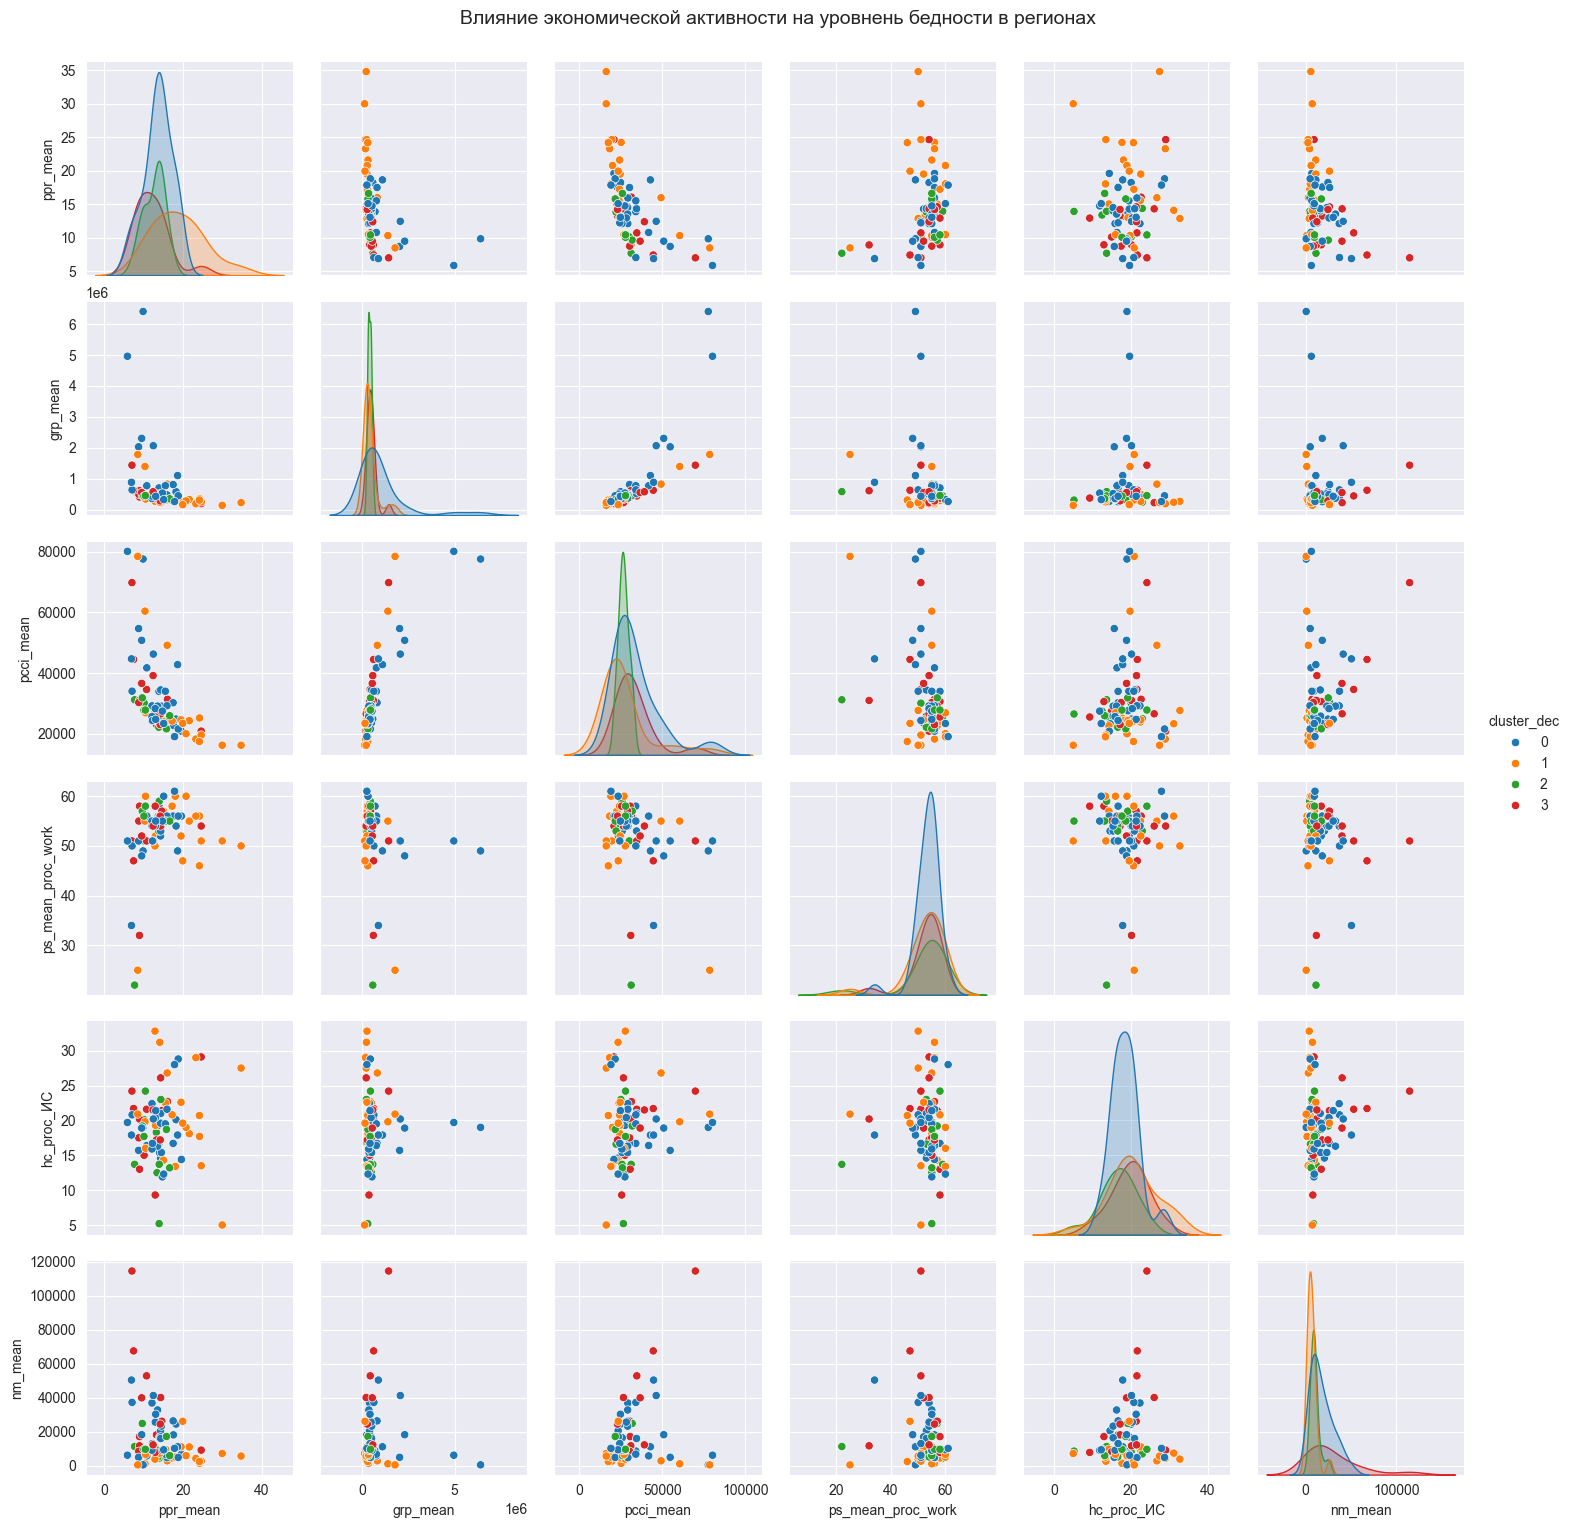

In [189]:
# таргет = Среднегодовой процент людей, живущих за чертой бедности
target = "ppr_mean"

# Экономика
sns.pairplot(df, vars = [target, "grp_mean", "pcci_mean", "ps_mean_proc_work", "hc_proc_ИС", "nm_mean"], hue="cluster_dec", palette="tab10")
plt.suptitle("Влияние экономической активности на уровнень бедности в регионах", fontsize=14, y=1.02)
plt.show()

## Вывод:

- На непредобработанных данных ***нейросетевой алгоритм кластеризации DEC**  не показал хороших результатов

- метрики слабые

- Тепловая карта средних значений показывает, что доля бедных регионов выявлена хуже чем в Kmeans-PCA.

- Хорошо выделяется признак grp в кластере 3

- На scatter диаграмме выборочных признаков видно, что алгоритм ловит долю бедных регионов в 1 кластер

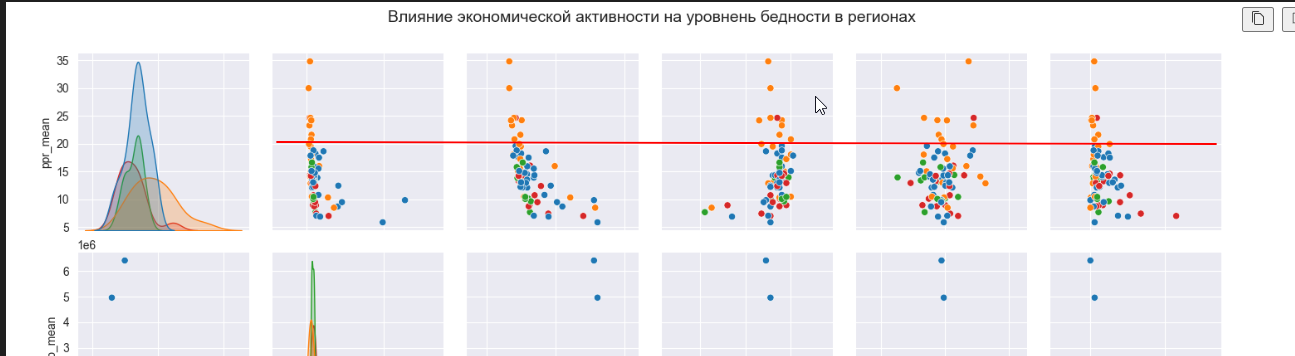